In [18]:
xlsxFilename = 'corr.xlsx'

# Function declaration 

In [19]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

def groupAnalysis(df, groupName):
    
    df_info = pd.DataFrame(index = df[groupName].unique(), \
                           columns = ['count', 'meanPeakError', 'meanAbsPeakError', \
                                      'peakErrorWithinT', 'stdPeakError', '5%', '95%'])

    df_grouped = df[[groupName] + ['peakErrors_1', 'peakErrorsAbs_1', 'peakErrorsWithinT_1']].groupby(groupName)

    df_info['meanPeakError'] = df_grouped['peakErrors_1'].mean()
    df_info['stdPeakError'] = df_grouped['peakErrors_1'].std()
    df_info['meanAbsPeakError'] = df_grouped['peakErrorsAbs_1'].mean()
    df_info['peakErrorWithinT'] = df_grouped['peakErrorsWithinT_1'].mean()
    df_info['count'] = df_grouped['peakErrors_1'].count()
    df_info['5%'] = df_grouped['peakErrors_1'].quantile(0.05)
    df_info['95%'] = df_grouped['peakErrors_1'].quantile(0.95)

    return df_info.sort_index()

# get the dataframe and do some processing 

In [20]:
df = pd.read_excel('/home/bradley/Documents/Research/peak_detect/' + xlsxFilename)

# drop null values 
df = df.dropna()

# remove trailing number on captures 
df['captureNames'] = df['captureNames'].apply(lambda s: re.sub(r'\d+$', '', s))

# define moisture levels in increments 
df['moistureLevel'] = ((df['vwcTrue'] * 2 // 0.1) + 1).astype('int32')
df['moistureLevel'] = df['moistureLevel'].map({1: "0-0.1",\
                                              2: "0-0.1",\
                                              3: "0.1-0.2",\
                                              4: "0.1-0.2",\
                                              5: "0.2-0.25",\
                                              6: "0.25-0.3",\
                                              7: "0.3-0.35",\
                                              8: ">0.35",\
                                              9: ">0.35",\
                                              10: ">0.35"})

# calculate absolute value of peak error 
df['peakErrorsAbs_1'] = abs(df['peakErrors_1'])


# define whether the experiment was active or passive 
df['tagType'] = df['expNames'].apply(lambda x: 'passive' if ('passive' in x) else 'active')

# determine if auto peak within t bins of manual peak 
t = 15
df['peakErrorsWithinT_1'] = np.where(df['peakErrors_1'].abs() <= t, True, False)

print(df.columns)

Index(['expNames', 'captureNames', 'peaksManual', 'peakPreds_1', 'peakPreds_2',
       'peakErrors_1', 'peakErrors_2', 'vwcTrue', 'vwcManual', 'vwcPreds_1',
       'vwcPreds_2', 'vwcErrors_1', 'vwcErrors_2', 'moistureLevel',
       'peakErrorsAbs_1', 'tagType', 'peakErrorsWithinT_1'],
      dtype='object')


# How close are we to the correct bin, on average? 

mean, std for error on bin prediction for template 1 = 2.8234265734265733, 28.667870213940926

Roughly 5% of bin predictions are more than than 51.0 below the measured bin
Roughly 5% of bin predictions are more than than 45.0 above the measured bin


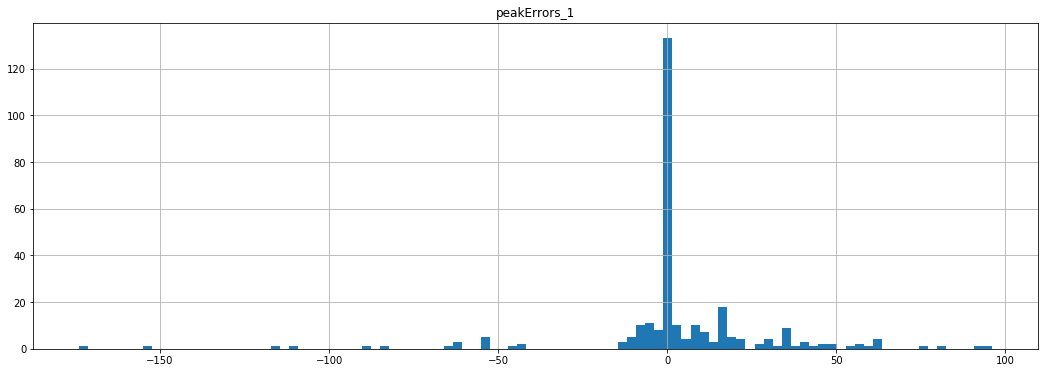

In [21]:
print('mean, std for error on bin prediction for template 1 = {}, {}\n'\
      .format(df['peakErrors_1'].mean(),df['peakErrors_1'].std()))

hist = df.hist(column = 'peakErrors_1', bins = 100, figsize = (18,6));

# 5% and 95% 
print('Roughly 5% of bin predictions are more than than {} below the measured bin'\
      .format(-1*df['peakErrors_1'].quantile(.05).round(0)))
print('Roughly 5% of bin predictions are more than than {} above the measured bin'\
      .format(df['peakErrors_1'].quantile(.95).round(0)))

# Group Analysis

In [22]:
# Analysis by Moisture Level

print(groupAnalysis(df, 'moistureLevel'))

          count  meanPeakError  meanAbsPeakError  peakErrorWithinT  \
0-0.1        50       4.940000          5.180000          0.860000   
0.1-0.2     120       3.841667          7.275000          0.866667   
0.2-0.25     19      31.815789         31.815789          0.421053   
0.25-0.3     49      12.163265         22.367347          0.489796   
0.3-0.35     29     -25.241379         26.413793          0.620690   
>0.35        19     -19.421053         27.842105          0.789474   

          stdPeakError      5%    95%  
0-0.1        12.493933   -1.00  36.00  
0.1-0.2      16.341932   -8.05  18.15  
0.2-0.25     26.137038    3.70  64.00  
0.25-0.3     27.475252  -44.00  54.20  
0.3-0.35     33.720125  -78.40   5.00  
>0.35        58.496264 -156.90  10.40  


In [23]:
# Analysis by experiment 

print(groupAnalysis(df, 'expNames'))

              count  meanPeakError  meanAbsPeakError  peakErrorWithinT  \
active_silt      50       3.980000          8.980000          0.900000   
clay_active      49      -3.755102         21.959184          0.448980   
clay_passive     49      11.877551         15.020408          0.714286   
farm_active      39      -1.705128         21.320513          0.794872   
farm_passive     50       4.120000         10.680000          0.820000   
silt_passive     49       1.448980         10.224490          0.775510   

              stdPeakError     5%    95%  
active_silt      24.307965  -10.0  37.70  
clay_active      33.441822  -63.0  36.00  
clay_passive     22.706123   -7.2  56.60  
farm_active      45.260317 -119.9  26.30  
farm_passive     22.537624  -13.1  44.85  
silt_passive     18.781708  -32.0  29.00  


In [24]:
# Analysis by tag

print(groupAnalysis(df, 'tagType'))

         count  meanPeakError  meanAbsPeakError  peakErrorWithinT  \
active     138      -0.373188         17.076087          0.710145   
passive    148       5.804054         11.966216          0.770270   

         stdPeakError    5%   95%  
active      34.392966 -63.0  36.0  
passive     21.735472 -11.3  49.3  
